Model Resuspension Check

In [ ]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *

import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]
#
path_months = '/results2/SalishSea/month-avg.202111/'
path_days_h = '/results2/SalishSea/nowcast-green.202111/'

In [ ]:
def monthly_prefix(date, path, area='biol_T_'):
    #
    prefix = os.path.join(path, f'SalishSeaCast_1m_{area}{date.strftime("%Y%m%d").lower()}*')
    file_name = glob.glob(prefix) 
    #
    return file_name

In [ ]:
def hourly_prefix(date, path, area='biol_T_'):
    #
    prefix = os.path.join(path, f'SalishSeaCast_1m_{area}{date.strftime("%Y%m%d").lower()}*')
    file_name = glob.glob(prefix) 
    #
    return file_name

Getting the data files for August 06, 2015 - March 10, 2016

In [ ]:
def date_files(date, path, prefix_type= 'grid_T.nc'):
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, folder + f'/SalishSea_1h_{date.strftime("%Y%m%d").lower()}_{date.strftime("%Y%m%d").lower()}_{prefix_type}*')
    file_name = glob.glob(prefix) 
    return file_name

In [ ]:
path = '/ocean/sallen/timbucktwo/exchange/'

In [ ]:
#
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return timestamps

#get_timestamps(datetime(2015,8,6), )

In [ ]:
begin = datetime(2015,8,6)
end = datetime(2015,9,6)
#end = datetime(2016,3,10)
t_len = (end - begin).days
#
dates = get_timestamps(begin,t_len)

In [ ]:
files = []
for i in range(t_len):
    files.append(date_files(dates[i][0],path))

Lets see how the bottom stress data looks like

In [ ]:
path_bat = '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc'
bathymetry = xr.open_dataset(path_bat).Bathymetry
cmap_bs = 'jet'
#cmap_bs.set_bad('grey')
cmap.set_bad('grey')
#
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask[0]

In [ ]:
model = xr.open_dataset(files[0][0])

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (14,12))
ax[0].pcolormesh(mask[0,:,:], cmap = 'gray')
bs = ax[0].pcolormesh(model['taubot'][0,:,:], cmap=cmap_bs, vmin = 0, vmax = 50)
ax[1].pcolormesh(mask[0,:,:], cmap = 'gray')
bat = ax[1].pcolormesh(bathymetry, cmap=cmap)
cbar = fig.colorbar(bs, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Borttom Stress $[N/m^{2}]$')
#
cbar1 = fig.colorbar(bat, ax=ax[1], location='right', shrink=0.8)
cbar1.set_label('Bathymetry [m]')

Lets see if we can get all the data contained in a single variable:

In [ ]:
data_list = []
for i in range(len(files)):
    data = xr.open_dataset(files[i][0])['taubot']
    data_list.append(data)

In [ ]:
combined = xr.concat(data_list, dim = 'time_counter')

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (14,12))
ax[0].pcolormesh(mask[0,:,:], cmap = 'gray')
bs = ax[0].pcolormesh(combined[0,:,:], cmap=cmap_bs, vmin = 0, vmax = 100)
ax[1].pcolormesh(mask[0,:,:], cmap = 'gray')
bat = ax[1].pcolormesh(bathymetry, cmap=cmap)
cbar = fig.colorbar(bs, ax=ax[0], location='right', shrink=0.8)
cbar.set_label('Borttom Stress $[N/m^{2}]$')
#
cbar1 = fig.colorbar(bat, ax=ax[1], location='right', shrink=0.8)
cbar1.set_label('Bathymetry [m]')

$$\textbf{Calculating u* from the model}$$

Lets see what we can get from the bottom velocities from the U component in the model.


- Problem to solve:


$$u = \frac{u^{*}}{k} \cdot ln(\frac{z}{z_{*}})$$

We need to get the estimate of the bottom stress ($u^{*}$):

$$u^{*} = \frac{u \cdot k}{ln(\frac{z}{z_{*}})}$$

Where $k = 0.42$, $z_{*} = 0.07 m$ and $z = e3t/2$ 

For $u^{2}$ on the T-grid we need to get the average velocity for each grid cell, as follows:

$u^{2} = \frac{1}{4} (u_{i,j} + u_{i-1,j})^{2} + \frac{1}{4} (v_{i,j} + v_{i, j-1}^2)$

From where we can get the magnitude of this velocity vector as $U = \sqrt{u^{2}}$, for then use the equation above as follows:

$$u^{*} = \frac{U \cdot k}{ln(\frac{z}{z_{*}})}$$

and get an the estimate of $u*$, where $u*^{2} \sim \tau$.


-------------------------------------------------------------------------------------------------------------------------------------------------

Load $\textbf{mbathy}$ and use it as the index of the last "water grid cell"

In [ ]:
path_bat = '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc'
bat_file = xr.open_dataset(path_bat)
mbathy = bat_file['mbathy'][0]

Load $\textbf{e3t}$ and $\textbf{vozocrtx}$, which are the grid layer thickness or "cell thickness" and the U component of velocity

In [ ]:
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
files_e3t = []
for i in range(t_len):
    files_e3t.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_T.nc'))
    #
files_U = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    #
files_V = []
for i in range(t_len):
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))

Get the velocity data at the right grid point according to mbathy

In [ ]:
# function for getting the right grid Z levels for the U velocity
def vel_grid(filename_U_vel, filename_V_vel, filename_e3t, mbathy_array):
    vel_file_U = xr.open_dataset(filename_U_vel)['vozocrtx'][0,:,:,:]
    e3t_file = xr.open_dataset(filename_e3t)['e3t'][0,:,:,:]
    vel_file_V = xr.open_dataset(filename_V_vel)['vomecrty'][0,:,:,:]    
    #
    #z_indices = np.arange(vel_file_U.sizes['depthu'])
    #mask = (z_indices[:, None, None] <= mbathy_array.values -1 ).transpose(0, 1, 2)
    # Create a file of nans, which shares the same dimensions as the velocity one
    #vel_U_corr = xr.full_like(vel_file_U.isel(depthu=0), np.nan)
    #vel_V_corr = xr.full_like(vel_file_V.isel(depthv=0), np.nan)
    #e3t_corr  = xr.full_like(e3t_file.isel(deptht=0), np.nan)
    #
    vel_U_corr = vel_file_U.isel(depthu=mbathy-1)
    vel_V_corr = vel_file_V.isel(depthv=mbathy-1)
    e3t_corr = e3t_file.isel(deptht=mbathy-1)
    #
    ###### U_STAR ######
    z = e3t_corr.copy() / 2
    z_star = 0.07
    k = 0.42
    vel_horizontal = xr.full_like(vel_U_corr, fill_value=np.nan)  
    #
    for j in range(len(vel_file_U['y'])):
        for i in range(len(vel_file_U['x'])):
            U_horizontal_2 = (1/4) * (vel_U_corr[j,i] + vel_U_corr[j,i-1]) ** 2
            V_horizontal_2 = (1/4) * (vel_V_corr[j,i] + vel_V_corr[j-1,i]) ** 2 
            vel_horizontal[j,i] = np.sqrt(U_horizontal_2 + V_horizontal_2)
    #
    # calculation of u-star (u*)
    #
    numerator = vel_horizontal * k 
    denominator = np.log(z/z_star)
    #
    u_star = numerator / denominator
    return vel_U_corr, vel_V_corr, e3t_corr, u_star        

In [ ]:
#xr.open_dataset(files_e3t[0][0])['sigma_theta']

In [ ]:
aa_u, bb_v, cc_e, U_star = vel_grid(files_U[0][0], files_V[0][0],files_e3t[0][0],mbathy)

In [ ]:
#U = (U_star * 2 / (0.42)) * np.log10((cc_e / 2) / 0.07)
#tc = 1000*0.0024*(U**2)

In [ ]:
tau = (U_star**2)*1024

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].pcolormesh(mask[0], cmap = 'grey')
taubot = ax[0].pcolormesh(model['taubot'][0,:,:], cmap = 'jet', vmin = 0, vmax = 20)
c_taubot = plt.colorbar(taubot, ax = ax[0])
c_taubot.set_label(r'Bottom Stress $(\tau)$ [$Kg/m \cdot s^{2}$]')
#
ax[1].pcolormesh(mask[0], cmap = 'grey')
star = ax[1].pcolormesh(tau, cmap = 'jet', vmin = 0, vmax = 20)
c_star = plt.colorbar(star, ax = ax[1])
c_star.set_label(r'$U*^{2} \cdot  \rho  \ $  [$Kg/m \cdot s^{2}$]')

#
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].scatter(model['taubot'][0,:,:], tau, c='k', s = 10)
#
ax[0].set_xlabel(r'Bottom Stress ($\tau$)')
ax[0].set_ylabel(r'U*$^{2} \cdot \rho $')
#
ax[0].grid(linestyle = '--')
#
ax[0].set_xlim(0,500)
ax[0].set_ylim(0,500)
#
ax[0].plot([0,500], [0,500], '--r')
#
#
ax[1].scatter(model['taubot'][0,:,:], tau, c='k', s = 10)
#
ax[1].set_xlabel(r'Bottom Stress ($\tau$)')
ax[1].set_ylabel(r'U*$^{2} \cdot \rho $')
#
ax[1].grid(linestyle = '--')
#
ax[1].set_xlim(0,200)
ax[1].set_ylim(0,200)
#
ax[1].plot([0,200], [0,200], '--r')
#
plt.tight_layout()

In [ ]:
cmap.set_bad('grey')
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(tau, tau['y'], '.k')
ax[0].set_title(r'$U*^{2} \cdot  \rho  \ $  [$Kg/m \cdot s^{2}$]')
ax[0].set_ylabel('Grid Y')
ax[0].set_ylim(0,len(tau['y']))
ax[0].set_xlim(0,500)
ax[0].grid()
#
ax[1].plot(model['taubot'][0],model['y'],'.k')
ax[1].set_title(r'Bottom Stress $(\tau)$ [$Kg/m \cdot s^{2}$]')
ax[1].set_xlim(0,500)
ax[1].set_ylim(0,len(tau['y']))
ax[1].grid()

#
axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
axins1.pcolormesh(bathymetry, cmap=cmap)
axins1.tick_params(which='both',bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False, labelright=True)
axins1.yaxis.tick_right()
#
plt.tight_layout()

SEE HOW IT'S VARYING IN TIME!!

Pick 3 points. One in the southern strait, norhtern strait and near Iona, to see if is there actually some resuspension there...

Now, how can I set a $\textbf{THRESHOLD}$ for my bottom resuspension due to values of $\tau$???

For now lets assume an arbitrary resuspension threshold :)
- This wonderful number will be $\tau _{critical} = 5 [\frac{Kg}{m \ s^{2}}]$

In [ ]:
t_critical = 1

In [ ]:
cmap.set_bad('grey')
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(tau, tau['y'], '.k')
ax[0].set_title(r'$U*^{2} \cdot  \rho  \ $  [$Kg/m \cdot s^{2}$]')
ax[0].set_ylabel('Grid Y')
ax[0].set_ylim(0,len(tau['y']))
ax[0].set_xlim(0,500)
ax[0].grid()
ax[0].vlines(x = t_critical, ymin = 0, ymax = len(tau['y']))
#
ax[1].plot(model['taubot'][0],model['y'],'.k')
ax[1].set_title(r'Bottom Stress $(\tau)$ [$Kg/m \cdot s^{2}$]')
ax[1].set_xlim(0,500)
ax[1].set_ylim(0,len(tau['y']))
ax[1].grid()
ax[1].vlines(x = t_critical, ymin = 0, ymax = len(tau['y']))

#
axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
axins1.pcolormesh(bathymetry, cmap=cmap)
axins1.tick_params(which='both',bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False, labelright=True)
axins1.yaxis.tick_right()
#
plt.tight_layout()

In [ ]:
tau_res = tau.where(tau>t_critical)
taubot_res = model['taubot'][0].where(model['taubot'][0]>t_critical)

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].pcolormesh(mask[0], cmap = 'grey')
taa_bot = ax[0].pcolormesh(taubot_res, cmap = cmocean.cm.oxy, vmin = 0, vmax = 0.01)
#c_taubot = plt.colorbar(taa_bot, ax = ax[0])
ax[0].set_title(r'Bottom Stress $(\tau)$ [$Kg/m \cdot s^{2}$]  > $\tau _{critical}$')
#
ax[1].pcolormesh(mask[0], cmap = 'grey')
star = ax[1].pcolormesh(tau_res, cmap = cmocean.cm.oxy, vmin = 0, vmax = 0.01)
#c_star = plt.colorbar(star, ax = ax[1])
ax[1].set_title(r'$U*^{2} \cdot  \rho  \ $  [$Kg/m \cdot s^{2}$] > $\tau _{critical}$')
#
plt.suptitle(r'$\tau _{critical} =  $' + str(t_critical) + r' [$Kg/m \cdot s^{2}$]')
plt.tight_layout()

Should this depend on Grain Size and Sediment Density?

$\tau _{cr} = \tau _{ci} \cdot g(\rho _{sediment} - \rho _{water}) * d_{particle \ size} \ : [\frac{Kg}{m \ s^{2}}]$

link : https://dec.vermont.gov/sites/dec/files/wsm/rivers/docs/assessment-protocol-appendices/O-Appendix-O-04-Shear-Stress.pdf#:~:text=Critical%20shear%20stress%20is%20the%20shear%20stress%20required,critical%20shear%20stress%2C%20channel%20degradation%20will%20likely%20result.

In [ ]:
g_d = 1250 # approx for gravel
t_ci = 0.06
d_p = 31 * (10**(-6)) # in micro m
t_threshold = t_ci * 10 * (g_d - 1024) * d_p

In [ ]:
t_threshold

Threshold curve based on: https://search.informit.org/doi/epdf/10.3316/informit.929741720399033

Threshold of motion by currents:

- $\theta _{cr} = \frac{0.24}{D*} + 0.055 \cdot [1 - exp(-0.020 \cdot D*)]$

Modified version:
- $\theta _{cr} = \frac{0.30}{1 + 1.2 \cdot D*} + 0.055 \cdot [1 - exp(-0.020 \cdot D*)]$

In [ ]:
f_sediments_1 = (0.24 / d_p) + 0.055*(1 - np.exp(-0.020*d_p)) 
f_sediments_2 = (0.30 / (1 + 1.2*d_p)) + 0.055*(1 - np.exp(-0.020*d_p)) 

In [ ]:
print(r'threshold f1: ', f_sediments_1)
print('Este esta malisimo')
print(r'threshold f2: ', f_sediments_2)
print('this one looks better')

In [ ]:
size = np.arange(1,1000)
formula_sediments_1 = (0.24 / size) + 0.055*(1 - np.exp(-0.020*size)) 
formula_sediments_2 = (0.30 / (1 + 1.2*size)) + 0.055*(1 - np.exp(-0.020*size)) 

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(formula_sediments_1, 'k')
ax.plot(formula_sediments_2, 'r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.01,1)
ax.set_xlabel('Grain Size (D*)')
ax.set_ylabel(r'$\theta _{cr}$')


In [ ]:
#d_size = 31
#rho_grain = 1300
#eq_threshold = np.divide(tau, (10 * (rho_grain - 1000)*(d_size*(10**(-6)))))

$$\textbf{Now, lets see how is varying in time!!}$$

Load the necessary data from specified grid points:

In [ ]:
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [ ]:
a, b = finder(49.195045, -123.301956) # location close to Iona Outfall in lat and lon coordinates
a1, b1 = 700, 135 # location at northern strait in grid points
a2, b2 = 520, 230# location at southern strait in grid points
a3, b3 = 360, 300 # location at the strait of JdF in grid points
a4, b4 = 255, 220 # location at the strait of JdF in grid points

############################ visualize points in the map #############################
fig, ax = plt.subplots(figsize = (6,8))
ax.pcolormesh(bathymetry, cmap=cmap)
ax.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
ax.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
ax.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
ax.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
ax.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
ax.legend()

In [ ]:
regions = ['NSoG','Iona', 'CSoG', 'SSoG', 'JdF']
colors = ['k', 'r', 'b', 'g', 'm']

The taubot data files are from August 06, 2015 to March 10, 2016. Lets select 4 days!!

In [ ]:
begin = datetime(2015,8,6)
end = datetime(2015,8,10)
#end = datetime(2016,3,10)
t_len = (end - begin).days # length of 4 days
#
dates = get_timestamps(begin,t_len)

In [ ]:
hourly_dates = pd.date_range(start=begin, end=end, freq='H')[:-1]

In [ ]:
files = []
for i in range(t_len):
    files.append(date_files(dates[i][0],path))

In [ ]:
def get_taubot_series(files_input, y_coordinate, x_coordinate, dimension = 'time_counter', variable = 'taubot'):
    #    
    data_list = []
    for i in range(len(files_input)):
        data = xr.open_dataset(files_input[i][0])[variable][:,y_coordinate, x_coordinate]
        data_list.append(data)
    #
    data_series = xr.concat(data_list, dim = dimension)    
    return data_series    

In [ ]:
############# taubot data for 4 days ############# 
taubot_days = np.array([get_taubot_series(files,a,b).values, get_taubot_series(files,a1,b1).values, get_taubot_series(files,a2,b2).values,get_taubot_series(files,a3,b3).values, get_taubot_series(files,a4,b4).values]).T

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
for n in range(len(regions)):
    ax.plot(hourly_dates, taubot_days[:,n], color = colors[n] ,label = regions[n])
    ax.legend()
axins = ax.inset_axes([1, 0, 0.3, 1])
axins.pcolormesh(bathymetry, cmap=cmap)
axins.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
axins.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
axins.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
axins.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
axins.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
axins.legend()
axins.tick_params(which='both',bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False, labelright=True)
#
ax.grid(linestyle = '--')
ax.set_ylabel(r'Model Bottom Stress (Taubot) [$Kg \cdot m^{-1} \cdot s^{-2}$]')    

In [ ]:
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
files_e3t = []
for i in range(t_len):
    files_e3t.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_T.nc'))
    #
files_U = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    #
files_V = []
for i in range(t_len):
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))

In [ ]:
# function for getting the right grid Z levels for the U velocity
def u_star_series(file_U_vel, file_V_vel, file_e3t, y_coor, x_coor, dimension = 'time_counter'):
    u_star_data = []
#
    d_index = mbathy[y_coor,x_coor] - 1
    for n in range(len(file_e3t)):
        vel_U = xr.open_dataset(file_U_vel[n][0])['vozocrtx'].isel(depthu=d_index)
        e3t = xr.open_dataset(file_e3t[n][0])['e3t'].isel(deptht=d_index)
        vel_V = xr.open_dataset(file_V_vel[n][0])['vomecrty'].isel(depthv=d_index)    
        #
        ###### U_STAR ######
        z = e3t.copy() / 2
        z_star = 0.07
        k = 0.42
        vel_horizontal = xr.full_like(vel_U[:,y_coor,x_coor], np.nan)  
        #
        U_horizontal_2 = (1/4) * (vel_U[:,y_coor,x_coor] + vel_U[:,y_coor,x_coor-1]) ** 2
        V_horizontal_2 = (1/4) * (vel_V[:,y_coor,x_coor] + vel_V[:,y_coor-1,x_coor]) ** 2 
        vel_horizontal = np.sqrt(U_horizontal_2 + V_horizontal_2)
    #
        # calculation of u-star (u*)
        #
        numerator = vel_horizontal * k 
        denominator = np.log(z[:,y_coor,x_coor]/z_star)
        #
        u_star = ((numerator / denominator) ** 2) * 1024
        u_star_data.append(u_star)
    #
    u_star_series = xr.concat(u_star_data, dim = dimension)
    
    #
    return u_star_series    

In [ ]:
############# calculated U_star data for 4 days ############# 
U_star_days = np.array([u_star_series(files_U, files_V, files_e3t, a, b).values, u_star_series(files_U, files_V, files_e3t, a1, b1).values, u_star_series(files_U, files_V, files_e3t, a2, b2).values, u_star_series(files_U, files_V, files_e3t, a3, b3).values, u_star_series(files_U, files_V, files_e3t, a4, b4).values]).T

Save data for no need of running the whole code every time

In [ ]:
data_U_star_days = pd.DataFrame(U_star_days, index=hourly_dates, columns = ['Iona', 'NSoG','CSoG', 'SSoG', 'JdF'])
data_U_star_days.to_csv('csv_U_star_days_calculated.csv')

In [ ]:
data_taubot_days = pd.DataFrame(taubot_days/2, index=hourly_dates, columns = ['Iona', 'NSoG','CSoG', 'SSoG', 'JdF'])
data_taubot_days.to_csv('csv_Taubot_days_model.csv')

In [ ]:
#U_star = u_star_series(files_U, files_V, files_e3t, a, b)

In [ ]:
#d_index = mbathy[a,b] - 1
#velocidad_U = xr.open_dataset(files_U[0][0])['vozocrtx'].isel(depthu=d_index)
#point_U = velocidad_U[:, a,b]
#point_U_1 = velocidad_U[:, a,b-1]
#velocidad_V = xr.open_dataset(files_V[0][0])['vomecrty'].isel(depthv=d_index)
#point_V = velocidad_V[:, a,b]
#point_V_1 = velocidad_V[:, a-1,b]
#grilla_e3t = xr.open_dataset(files_e3t[0][0])['e3t'].isel(deptht=d_index)
#
#U_horizontal_2 = (1/4) * (point_U + point_U_1) ** 2
#V_horizontal_2 = (1/4) * (point_V + point_V_1) ** 2 
#vel_horizontal = np.sqrt(U_horizontal_2 + V_horizontal_2)
#### Calculo manual de U* ####
#numerator = vel_horizontal * 0.42 
#denominator = np.log((grilla_e3t[:,a,b]/2)/0.07)
#
#u_star = ((numerator / denominator) ** 2) * 1024

In [ ]:
############# MAKING SURE THAT U_star is being calculated correctly ################# 
#
# NO ERROR IN VELOCITIES (U_horizontal_2, V_horizontal_2 and vel_horizontal). It's the same between function and individual calculation
#
# NO ERROR IN FRACTION BEFORE GETTING U_star
#
#### Calculation is correct!! ####

In [ ]:
#plt.plot(u_term_check[:24] - U_horizontal_2, label = 'U_term')
#plt.plot(v_term_check[:24] - V_horizontal_2, label = 'V_term')
#plt.plot(numerator_check[:24] - numerator, label = 'numerator_term')
#plt.plot(denominator_check[:24] - denominator, label = 'denominator_term')
#plt.plot(np.sqrt(U_horizontal_2 + V_horizontal_2) - np.sqrt(u_term_check[:24] + v_term_check[:24]), label = 'velocity_final_term')
#plt.plot(u_star_check[:24] - u_star, label = 'U_star')
#plt.legend()



In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
for n in range(len(regions)):
    ax.plot(hourly_dates, U_star_days[:,n], color = colors[n] ,label = regions[n])
    ax.legend()
axins = ax.inset_axes([1, 0, 0.3, 1])
axins.pcolormesh(bathymetry, cmap=cmap)
axins.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
axins.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
axins.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
axins.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
axins.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
axins.legend()
axins.tick_params(which='both',bottom=False, top=False, left=False, right=True, labelbottom=False, labelleft=False, labelright=True)
#
ax.grid(linestyle = '--')
ax.set_ylabel(r'Calculated Bottom Stress ($U^{*2} \cdot \rho$) [$Kg \cdot m^{-1} \cdot s^{-2}$]') 

In [ ]:
B = [b, b1, b2 ,b3 ,b4]
A = [a, a1, a2 ,a3 ,a4]

Look at their correlation:

In [ ]:
correlations = np.zeros(len(taubot_days[0,:]))
for i in range(len(correlations)):
    correlations[i] = np.corrcoef(taubot_days[:,i], U_star_days[:,i])[0][1]
corr = np.round(correlations,3).astype(str)    

Compare the different time series between the two:

In [ ]:
fig, ax = plt.subplots(5,figsize = (12,12))
for n in range(len(regions)):
    ax[n].plot(hourly_dates, taubot_days[:,n], '--', color = colors[n] ,label = 'Taubot')
    ax[n].plot(hourly_dates, U_star_days[:,n], color = colors[n] ,label = r'$U^{*2} \cdot \rho$')
    ax[n].legend(loc = 'upper left')
    ax[n].grid(linestyle = '--')

axins = ax[4].inset_axes([1, 0, 0.3, 5.8])
axins.pcolormesh(bathymetry, cmap=cmap)
axins.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
axins.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
axins.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
axins.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
axins.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
axins.legend()
axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False, labelright=False)
#
for i, txt in enumerate(corr):
    axins.annotate('r = '+txt, (B[i] + 20, A[i] - 5)) 
#
#plt.tight_layout()
ax[2].set_ylabel(r'$\tau$  [$Kg \cdot m^{-1} \cdot s^{-2}$]') 
#
ax[0].set_title(r'Time Series for $Taubot$ and $U^{*2} \cdot \rho$')

In [ ]:
U_star_days.shape

In [ ]:
(taubot_days[:,0] - U_star_days[:,0]).shape

Significant difference between our reference bottom stress from the model ($\textbf{taubot}$) and the estimated bottom stress from  $U^{*2} \cdot \rho$. Calculations were checked and it's correct. It may be an important difference in how $\textbf{taubot}$ is being calculated within the model, which would explain these difference

In [ ]:

fig, ax = plt.subplots(5,figsize = (12,12))
for n in range(len(regions)):
    ax[n].plot(hourly_dates, (taubot_days[:,n] - U_star_days[:,n]), '--', color = colors[n] ,label = r'Taubot - $U^{*2} \cdot \rho$')
    ax[n].legend(loc = 'upper left')
    ax[n].grid(linestyle = '--')
#
axins = ax[4].inset_axes([1, 0, 0.3, 5.8])
axins.pcolormesh(bathymetry, cmap=cmap)
axins.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
axins.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
axins.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
axins.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
axins.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
axins.legend()
axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False, labelright=False)
#
for i, txt in enumerate(corr):
    axins.annotate('r = '+txt, (B[i] + 20, A[i] - 5)) 
#
#plt.tight_layout()
ax[2].set_ylabel(r'$\tau$  [$Kg \cdot m^{-1} \cdot s^{-2}$]') 
#
ax[0].set_title(r'Time Series for the Difference between $Taubot$ and $U^{*2} \cdot \rho$')

Potential correction for Taubot:
- Taubot is 2 times higher than the calculated bottom stress

In [ ]:
fig, ax = plt.subplots(5,figsize = (12,12))
for n in range(len(regions)):
    ax[n].plot(hourly_dates, taubot_days[:,n] / 2, '--', color = colors[n] ,label = 'Taubot')
    ax[n].plot(hourly_dates, U_star_days[:,n], color = colors[n] ,label = r'$U^{*2} \cdot \rho$')
    ax[n].legend(loc = 'upper left')
    ax[n].grid(linestyle = '--')

axins = ax[4].inset_axes([1, 0, 0.3, 5.8])
axins.pcolormesh(bathymetry, cmap=cmap)
axins.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
axins.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
axins.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
axins.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
axins.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
axins.legend()
axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False, labelright=False)
#
for i, txt in enumerate(corr):
    axins.annotate('r = '+txt, (B[i] + 20, A[i] - 5)) 
#
#plt.tight_layout()
ax[2].set_ylabel(r'$\tau$  [$Kg \cdot m^{-1} \cdot s^{-2}$]') 
#
ax[0].set_title(r'Time Series for ($Taubot$ / 2) and $U^{*2} \cdot \rho$')

Differences still not just by this factor of 2, something else is wrong...

In [ ]:
# function for getting the right grid Z levels for the U velocity
def taubot_series(file_U_vel, file_V_vel, file_e3t, y_coor, x_coor, dimension = 'time_counter'):
    taubot_data = []
#
    d_index = mbathy[y_coor,x_coor] - 1
    for n in range(len(file_e3t)):
        vel_U = xr.open_dataset(file_U_vel[n][0])['vozocrtx'].isel(depthu=d_index)
        e3t = xr.open_dataset(file_e3t[n][0])['e3t'].isel(deptht=d_index)
        vel_V = xr.open_dataset(file_V_vel[n][0])['vomecrty'].isel(depthv=d_index)    
        #
        ###### U_STAR ######
        z = e3t.copy() / 2
        z_star = 0.07
        k = 0.42
        # zbfrt for Taubot
        zbfrt = (k / (np.log((z) / z_star)))
        #
        bfrau = (zbfrt[:,y_coor, x_coor] + zbfrt[:,y_coor, x_coor - 1]) / 2
        bfrav = (zbfrt[:,y_coor, x_coor] + zbfrt[:,y_coor - 1, x_coor]) / 2
        # This is U*
        bu = bfrau * ((vel_U[:,y_coor,x_coor] + vel_U[:,y_coor,x_coor-1]) / 2)
        bv = bfrav * ((vel_V[:,y_coor,x_coor] + vel_V[:,y_coor-1,x_coor]) / 2) 
        #
        TAUBOT = 1024 * (np.sqrt((bu ** 2) + (bv ** 2))) ** 2
        #
        taubot_data.append(TAUBOT)



    taubot_series = xr.concat(taubot_data, dim = dimension)

    #
    return taubot_series  

In [ ]:
tau1 = taubot_series(files_U, files_V, files_e3t, a, b).values

In [ ]:
TAUBOT_days = np.array([taubot_series(files_U, files_V, files_e3t, a, b).values, taubot_series(files_U, files_V, files_e3t, a1, b1).values, taubot_series(files_U, files_V, files_e3t, a2, b2).values, taubot_series(files_U, files_V, files_e3t, a3, b3).values, taubot_series(files_U, files_V, files_e3t, a4, b4).values]).T

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
#
ax.plot(hourly_dates, taubot_days[:,0] / 2, '--', color = colors[0] ,label = 'Taubot')
ax.plot(hourly_dates, tau1, color = colors[0] ,label = 'Calculated Taubot')
ax.plot(hourly_dates, U_star_days[:,0], '.-', color = colors[0] ,label = 'Calculated U*')

ax.legend()

In [ ]:
fig, ax = plt.subplots(5,figsize = (12,12))
for n in range(len(regions)):
    ax[n].plot(hourly_dates, taubot_days[:,n], '--', color = colors[n] ,label = 'Taubot')
    ax[n].plot(hourly_dates, TAUBOT_days[:,n], color = colors[n] ,label = 'Calculated Taubot')
    ax[n].plot(hourly_dates, U_star_days[:,n], '.-' ,color = colors[n] ,label = r'Calculated $\rho \cdot u*^{2}$')
    ax[n].legend(loc = 'upper left')
    ax[n].grid(linestyle = '--')
#
axins = ax[4].inset_axes([1, 0, 0.3, 5.8])
axins.pcolormesh(bathymetry, cmap=cmap)
axins.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
axins.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
axins.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
axins.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
axins.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
axins.legend()
axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False, labelright=False)
#
for i, txt in enumerate(corr):
    axins.annotate('r = '+txt, (B[i] + 20, A[i] - 5)) 
#
#plt.tight_layout()
ax[2].set_ylabel(r'$\tau$  [$Kg \cdot m^{-1} \cdot s^{-2}$]') 
#
ax[0].set_title(r'Time Series for Taubot, Calculated Taubot and Calculated Bottom Stress')

------------------------------------------------------------------------------------------------------------------------------------------------------------

**From this part, working on Taubot, Calculated Bottom Stress and finding the correct way of how taubot is being calculated**

Differences between the Calculated Bottom Stress and the Calculated Taubot could be due to the indexing of e3t, being calculated at the u-points of U and V in the case of the calculated taubot, while this is not being done for the calculated bottom stress.

For the differences between Taubot and Calculated Taubot...NO IDEA. If we are assuming the same way of calculating the bottom stress, which is $\tau \sim \rho \cdot u*^{2} $, then it shouldn't be that different

Lets check the two methods/equations for the Calculated Bottom Stress and the equation used by the Reference Taubot:

- For the Calculated Bottom Stress we have:

$$u^{*} = \frac{U \cdot \kappa}{ln(z/z_{*})}$$

where, 

$$U = \sqrt{(u)^{2} + (v)^{2}}$$

and, $\textbf{u}$ and $\textbf{v}$ are the horizontal components of the velocity at a $\textbf{t point}$, which means:

$$u_{t point} = \frac{u_{i,j} + u_{i-1,j}}{2}$$
$$v_{t point} = \frac{v_{i,j} + v_{i,j-1}}{2}$$

$$\Rightarrow U_t = \sqrt{(u_{t point})^2 + (v_{t point})^2}$$

Therefore, the final $u^{*}$ is expresssed as:

$$u^{*} = \frac{U_t \cdot \kappa}{ln(z/z_{*})}$$

and our bottom stress can be estimated as:

$$\tau \sim \rho \cdot u^{*^{2}}$$

- For the Reference Taubot equation:

$$zbfrt = \bigg (\frac{\kappa}{ln(z/z_{*})}\bigg)^{2}$$

, where the term without velocity is isolated and squared

$$bfrau = \frac{zbfrt_{i,j} + zbfrt_{i-1,j}}{2}$$ 
$$bfrav = \frac{zbfrt_{i,j} + zbfrt_{i,j-1}}{2}$$ 

, and both terms are the averaged position of z (e3t/2) for being placed in the u grid

Then, we define

$$bu = bfrau \cdot u$$
$$bv = bfrav \cdot u$$

, where $\textbf{u}$ and $\textbf{v}$ are placed in the t grid, as follows:

$$u_t = \frac{u_{i,j} + u_{i-1,j}}{2}$$ 
$$v_t = \frac{v_{i,j} + v_{i,j-1}}{2}$$ 

Finally, we get the output for $\textbf{Taubot}$:

$$taubot = \rho \cdot \sqrt{(bu^2 + bv^2)}$$

------------------------------------------------------------------------------------------------------------------------------------------------------------

- Differences:

If we isolate the term 

$$ (*) = \frac{\kappa}{ln(z/z_{*})}$$

The reference Taubot is calculating the following estimate:

$$Taubot = \rho \cdot U \cdot (*)^{2}$$

While, the calculated Bottom Stress equation is doing:

$$\tau \sim \rho \cdot U^2 \cdot (*)^2$$

In [1]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *

import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
def date_files(date, path, prefix_type= 'grid_T.nc'):
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, folder + f'/SalishSea_1h_{date.strftime("%Y%m%d").lower()}_{date.strftime("%Y%m%d").lower()}_{prefix_type}*')
    file_name = glob.glob(prefix) 
    return file_name

In [4]:
def get_timestamps(start,length):
    timestamps=[]
    duration = timedelta(days=length)
    for day in range(duration.days):
        timestamps.append([start + timedelta(days=day)])
    return timestamps

In [27]:
begin = datetime(2015,8,6)
end = datetime(2015,9,6)
#end = datetime(2016,3,10)
t_len = (end - begin).days
#
dates = get_timestamps(begin,t_len)
hourly_dates = pd.date_range(start=begin, end=end, freq='H')[:-1]

In [8]:
path_days_h = '/results2/SalishSea/nowcast-green.202111/'
files_e3t = []
for i in range(t_len):
    files_e3t.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_T.nc'))
    #
files_U = []
for i in range(t_len):
    files_U.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_U.nc'))
    #
files_V = []
for i in range(t_len):
    files_V.append(date_files(dates[i][0],path_days_h, prefix_type = 'grid_V.nc'))

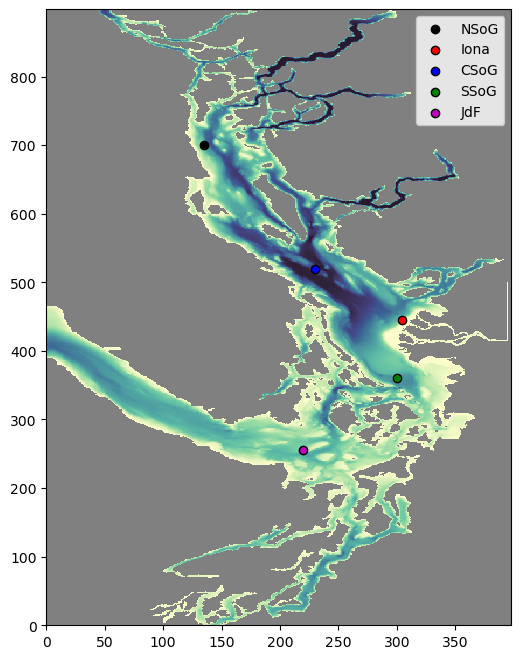

In [18]:
path_bat = '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc'
bathymetry = xr.open_dataset(path_bat).Bathymetry
cmap.set_bad('grey')
#
path_bat = '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc'
bat_file = xr.open_dataset(path_bat)
mbathy = bat_file['mbathy'][0]
#
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i
#################################################################################################    
a, b = finder(49.195045, -123.301956) # location close to Iona Outfall in lat and lon coordinates
a1, b1 = 700, 135 # location at northern strait in grid points
a2, b2 = 520, 230# location at southern strait in grid points
a3, b3 = 360, 300 # location at the strait of JdF in grid points
a4, b4 = 255, 220 # location at the strait of JdF in grid points

############################ visualize points in the map #############################
fig, ax = plt.subplots(figsize = (6,8))
ax.pcolormesh(bathymetry, cmap=cmap)
ax.scatter(b1, a1, c='k', edgecolor = 'k', label = 'NSoG')
ax.scatter(b, a, c='r', edgecolor = 'k', label = 'Iona')
ax.scatter(b2, a2, c='b', edgecolor = 'k', label = 'CSoG')
ax.scatter(b3, a3, c='g', edgecolor = 'k', label = 'SSoG')
ax.scatter(b4, a4, c='m', edgecolor = 'k', label = 'JdF')
ax.legend()

Load the data

In [11]:
model_taubot = pd.read_csv('csv_Taubot_days_model.csv') 
calculated_tau = pd.read_csv('csv_U_star_days_calculated.csv') 

Text(0.5, 1.0, 'Correlation between Reference Taubot and Calculated Taubot r = 0.4203707136047367')

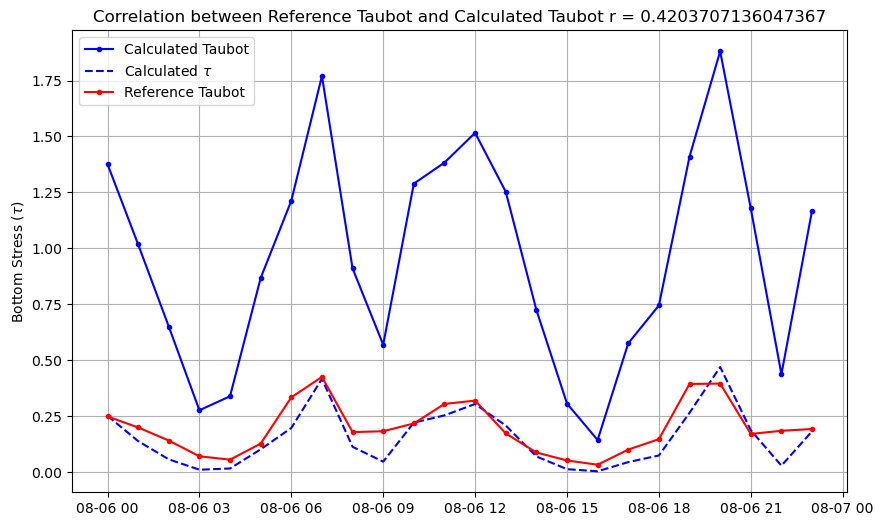

In [32]:
#
y_coor = a1
x_coor = b1
d_index = mbathy[y_coor,x_coor] - 1
#
vel_U = xr.open_dataset(files_U[0][0])['vozocrtx'].isel(depthu=d_index)
e3t = xr.open_dataset(files_e3t[0][0])['e3t'].isel(deptht=d_index)
vel_V = xr.open_dataset(files_V[0][0])['vomecrty'].isel(depthv=d_index)
#
###### U_STAR ######
#zu = (e3t[:,y_coor, x_coor] + e3t[:,y_coor, x_coor+1]) / 4
#zv = (e3t[:,y_coor, x_coor] + e3t[:,y_coor+1, x_coor]) / 4

z_star = 0.07
k = 0.42
# zbfrt for Taubot

zbfrt = (k / (np.log((e3t/2) / z_star)))**2
#zbfrt_V = (k / (np.log((zv) / z_star))) ** 2

#
bfrau = (zbfrt[:,y_coor, x_coor] + zbfrt[:,y_coor, x_coor + 1]) / 2
bfrav = (zbfrt[:,y_coor, x_coor] + zbfrt[:,y_coor + 1, x_coor]) / 2
# This is U*
bu = ((vel_U[:,y_coor,x_coor] * bfrau + vel_U[:,y_coor,x_coor-1] * bfrau) / 2)
bv = ((vel_V[:,y_coor,x_coor] * bfrav + vel_V[:,y_coor-1,x_coor] * bfrav) / 2)
#
TAUBOT = (1024 * (np.sqrt((bu)**2 + (bv)**2)))
#
#
################### Changes in Reference Taubot #############################
#taubot_test = xr.open_dataset(files_U[0][0])['vozocrtx'].isel(depthu=d_index)
#
#TBOT_x = (taubot_test[:,y_coor, x_coor] + taubot_test[:,y_coor, x_coor - 1]) / 2 
#TBOT_y = (taubot_test[:,y_coor, x_coor] + taubot_test[:,y_coor-1, x_coor]) / 2 
#TBOT = np.sqrt((TBOT_x) ** 2 + (TBOT_y) ** 2)
#
#
#
corr_taubots = np.corrcoef(TAUBOT, model_taubot['CSoG'][:24].values)[1][0]
# PLOT
fig, ax  = plt.subplots(figsize = (10,6))
ax.plot(hourly_dates[:24], TAUBOT, '.-b', label = 'Calculated Taubot')
ax.plot(hourly_dates[:24], calculated_tau['NSoG'][:24].values, '--b', label = r'Calculated $\tau$')
ax.plot(hourly_dates[:24], model_taubot['NSoG'][:24].values, '.-r', label = 'Reference Taubot') 
ax.legend()
ax.grid()
ax.set_ylabel(r'Bottom Stress ($\tau$)')
ax.set_title(r'Correlation between Reference Taubot and Calculated Taubot r = ' + str(corr_taubots))

For the Calculated Bottom Stress, the reasoning would be some issue with the squared terms. Because, we see a similar trend in some cases, but the main problem is the difference between both: this lead me to think that the squared terms are leading to these steep differences while keeping a similar pattern through time...

Lets try getting u* at each grid point and then take the average:

In [33]:
y_coor = a
x_coor = b
d_index = mbathy[y_coor,x_coor] - 1
d_index.values

array(25)

Points on T-grid, U-grid and V-grid for each variable:

In [34]:
# Centered Box
e3t_c = xr.open_dataset(files_e3t[0][0])['e3t'].isel(deptht=(mbathy[y_coor,x_coor] - 1))
# Left Box
e3t_l = xr.open_dataset(files_e3t[0][0])['e3t'].isel(deptht=(mbathy[y_coor,x_coor-1] - 1))
# Right Box
e3t_r = xr.open_dataset(files_e3t[0][0])['e3t'].isel(deptht=(mbathy[y_coor,x_coor+1] - 1))
# Bottom Box
e3t_b = xr.open_dataset(files_e3t[0][0])['e3t'].isel(deptht=(mbathy[y_coor-1,x_coor] - 1))
# Top Box
e3t_t = xr.open_dataset(files_e3t[0][0])['e3t'].isel(deptht=(mbathy[y_coor+1,x_coor] - 1))

In [35]:
# left box and centered box
z_lc = ((e3t_l[:,y_coor, x_coor-1] / 2) + (e3t_c[:,y_coor, x_coor] / 2))/2 # e3t between both left and centered boxes
k_term_lc = k / (np.log(z_lc/z_star))
#
# top box and centered box
z_tc = ((e3t_t[:,y_coor+1, x_coor] / 2) + (e3t_c[:,y_coor, x_coor] / 2))/2 # e3t between both top and centered boxes
k_term_tc = k / (np.log(z_tc/z_star))
#
# right box and centered box
z_rc = ((e3t_r[:,y_coor, x_coor+1] / 2) + (e3t_c[:,y_coor, x_coor] / 2))/2 # e3t between both right and centered boxes
k_term_rc = k / (np.log(z_rc/z_star))
#
# bottom box and centered box
z_tb = ((e3t_b[:,y_coor-1, x_coor] / 2) + (e3t_c[:,y_coor, x_coor] / 2))/2 # e3t between both bottom and centered boxes
k_term_bc = k / (np.log(z_tb/z_star))

With the code above, we have z (from e3t) on the U and V grid for our velocity components. Now, we can directly index U and V for getting U* at those points

In [36]:
vel_U = xr.open_dataset(files_U[0][0])['vozocrtx'].isel(depthu=d_index)
vel_V = xr.open_dataset(files_V[0][0])['vomecrty'].isel(depthv=d_index)
# left velocity u_{i,j}
u_star_left = vel_U[:,y_coor, x_coor] * k_term_lc
# Right velocity u_{i+1,j}
u_star_right = vel_U[:,y_coor, x_coor+1] * k_term_rc
# Bottom velocity v_{i,j}
u_star_bottom = vel_V[:,y_coor-1, x_coor] * k_term_bc
# Top velocity v_{i,j+1}
u_star_top = vel_V[:,y_coor+1, x_coor] * k_term_tc

In [37]:
avg_u_star_U = (u_star_left + u_star_right) / 2
avg_u_star_V = (u_star_bottom + u_star_top) / 2

In [38]:
b_stress = 1024 * (np.sqrt(avg_u_star_U**2 + avg_u_star_V**2)) ** 2

Text(0.5, 1.0, 'Correlation between Reference Taubot and Calculated Taubot r = 0.4203707136047367')

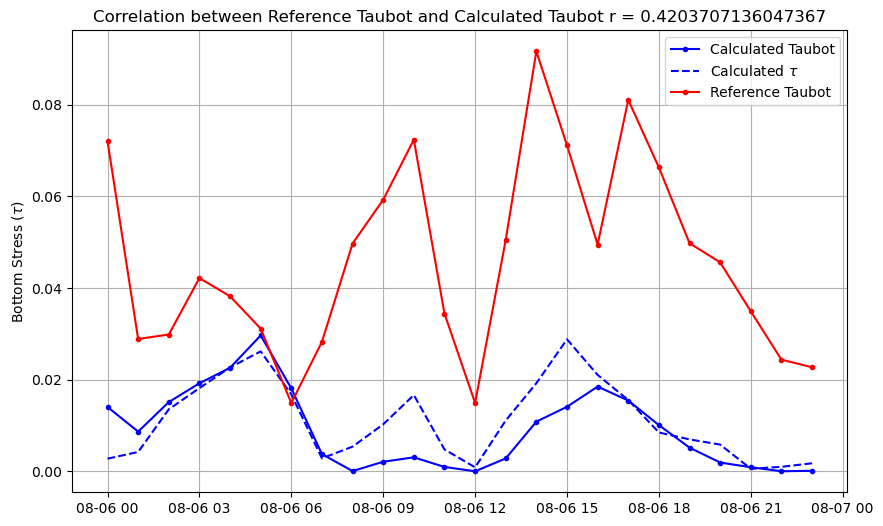

In [39]:
fig, ax  = plt.subplots(figsize = (10,6))
ax.plot(hourly_dates[:24], b_stress, '.-b', label = 'Calculated Taubot')
ax.plot(hourly_dates[:24], calculated_tau['Iona'][:24].values, '--b', label = r'Calculated $\tau$')
ax.plot(hourly_dates[:24], model_taubot['Iona'][:24].values, '.-r', label = 'Reference Taubot')  
ax.legend()
ax.grid()
ax.set_ylabel(r'Bottom Stress ($\tau$)')
ax.set_title(r'Correlation between Reference Taubot and Calculated Taubot r = ' + str(corr_taubots))

In [40]:
zu_1 = (e3t[:,y_coor, x_coor] + e3t[:,y_coor, x_coor-1]) / 4 # e3t for u in u grid
zv_1 = (e3t[:,y_coor, x_coor] + e3t[:,y_coor-1, x_coor]) / 4 # e3t for v in v grid
#
zu_2 = (e3t[:,y_coor, x_coor] + e3t[:,y_coor, x_coor+1]) / 4 # e3t for u in u grid
zv_2 = (e3t[:,y_coor, x_coor] + e3t[:,y_coor+1, x_coor]) / 4 # e3t for v in v grid
#
z_star = 0.07
k = 0.42
# FOR u_{i,j}
ku_term1 = k / (np.log(zu_1/z_star))
u_star1 = ku_term1 * vel_U[:, y_coor, x_coor]
# FOR v_{i,j}
kv_term1 = k / (np.log(zv_1/z_star))
v_star1 = kv_term1 * vel_V[:, y_coor, x_coor]
# FOR u_{i+1,j}
ku_term2 = k / (np.log(zu_2/z_star))
u_star2 = ku_term2 * vel_U[:, y_coor, x_coor+1]
# FOR v_{i,j}
kv_term2 = k / (np.log(zv_2/z_star))
v_star2 = kv_term2 * vel_V[:, y_coor+1, x_coor]

In [41]:
u_star_avg = (u_star1 + u_star2) / 2
v_star_avg = (v_star1 + v_star2) / 2
#
U_star_test = np.sqrt((u_star_avg)**2 + (v_star_avg)**2) 

Text(0.5, 1.0, 'Correlation between Reference Taubot and Calculated Taubot r = 0.4203707136047367')

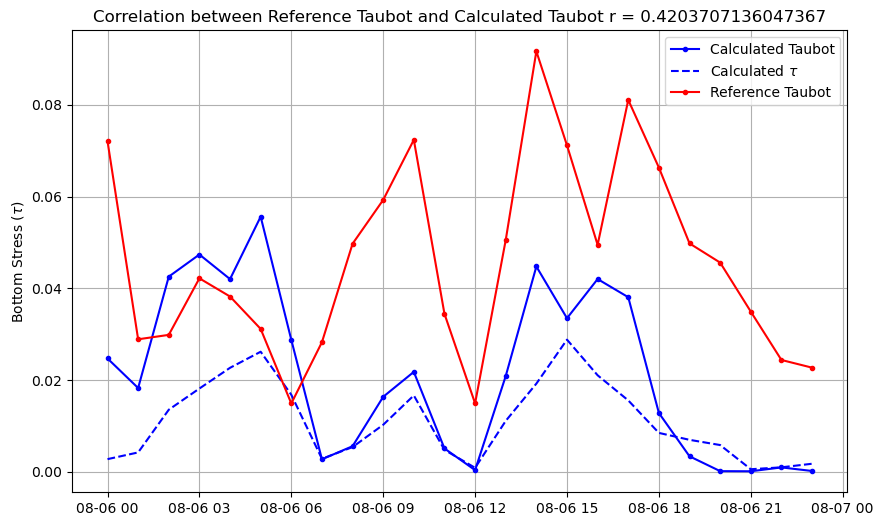

In [42]:
U_star_total = 1024 * (U_star_test**2)
#
fig, ax  = plt.subplots(figsize = (10,6))
ax.plot(hourly_dates[:24], U_star_total, '.-b', label = 'Calculated Taubot')
ax.plot(hourly_dates[:24], calculated_tau['Iona'][:24].values, '--b', label = r'Calculated $\tau$')
ax.plot(hourly_dates[:24], model_taubot['Iona'][:24].values, '.-r', label = 'Reference Taubot')   
ax.legend()
ax.grid()
ax.set_ylabel(r'Bottom Stress ($\tau$)')
ax.set_title(r'Correlation between Reference Taubot and Calculated Taubot r = ' + str(corr_taubots))